In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
import torch.optim as optim

import numpy as np
import pandas as pd
import math

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score

In [ ]:
norm_trainset = pd.read_csv('final_trainset.csv')
norm_testset = pd.read_csv('final_testset.csv')

In [ ]:
norm_trainset['label'] = norm_trainset['label'].astype(float)

In [ ]:
class TabularDataset(Dataset):
  def __init__(self, data, labels):
    self.data = torch.tensor(data.values, dtype=torch.float32)
    self.labels = torch.tensor(labels.values, dtype=torch.float32)

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    return self.data[idx], self.labels[idx]

In [ ]:
class MLP(nn.Module):
  def __init__(self, num_features, num_classes=1):
    super(MLP, self).__init__()
    self.fc1 = nn.Linear(num_features, 64)
    self.fc2 = nn.Linear(64, 32)
    self.fc3 = nn.Linear(32, num_classes)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

In [ ]:
def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for data, target in train_loader:
            optimizer.zero_grad()  # Clear gradients
            output = model(data)  # Forward pass
            loss = criterion(output, target.view(-1, 1))  # Calculate loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights
            running_loss += loss.item()
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

# Fungsi untuk mengevaluasi model
def evaluate_model(model, test_loader):
    model.eval()
    all_targets = []
    all_predictions = []
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            predicted = (output > 0.5).float()  # Thresholding
            total += target.size(0)
            correct += (predicted.view(-1) == target).sum().item()
            all_targets.extend(target.cpu().numpy())
            all_predictions.extend(predicted.view(-1).cpu().numpy())

    accuracy = 100 * correct / total
    print(f'Accuracy of the model on the test set: {accuracy:.4f}%')

    conf_matrix = confusion_matrix(all_targets, all_predictions)
    precision = precision_score(all_targets, all_predictions)
    recall = recall_score(all_targets, all_predictions)
    f1 = f1_score(all_targets, all_predictions)

    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'Accuracy: {accuracy:.4f}')
    print(f'F1 Score: {f1:.4f}')

    print("Confusion Matrix:")
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

In [ ]:
torch.manual_seed(42)

X = norm_trainset.iloc[:, :-1]
y = norm_trainset.iloc[:, -1]

dataset = TabularDataset(X, y)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [ ]:
num_features = X.shape[1]
lr = 0.001
epochs = 20

num_class_0 = (y == 0).sum()
num_class_1 = (y == 1).sum()

model = MLP(num_features=num_features)
pos_weight = torch.tensor([num_class_0 / num_class_1])
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(model.parameters(), lr=lr)

In [ ]:
# Melatih model
train_model(model, train_loader, criterion, optimizer, num_epochs=20)

Epoch [1/20], Loss: 0.1083
Epoch [2/20], Loss: 0.0904
Epoch [3/20], Loss: 0.0866
Epoch [4/20], Loss: 0.0845
Epoch [5/20], Loss: 0.0830
Epoch [6/20], Loss: 0.0821
Epoch [7/20], Loss: 0.0815
Epoch [8/20], Loss: 0.0807
Epoch [9/20], Loss: 0.0804
Epoch [10/20], Loss: 0.0797
Epoch [11/20], Loss: 0.0792
Epoch [12/20], Loss: 0.0788
Epoch [13/20], Loss: 0.0783
Epoch [14/20], Loss: 0.0778
Epoch [15/20], Loss: 0.0778
Epoch [16/20], Loss: 0.0774
Epoch [17/20], Loss: 0.0770
Epoch [18/20], Loss: 0.0766
Epoch [19/20], Loss: 0.0765
Epoch [20/20], Loss: 0.0763


Accuracy of the model on the test set: 92.4235%
Precision: 0.9871
Recall: 0.8999
Accuracy: 92.4235
F1 Score: 0.9415
Confusion Matrix:


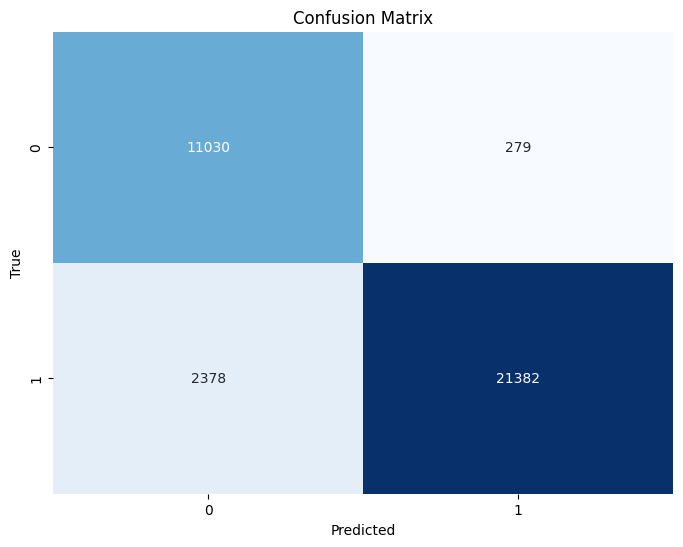

In [ ]:
evaluate_model(model, val_loader)

Accuracy of the model on the test set: 91.2294%
Precision: 0.9239
Recall: 0.9161
Accuracy: 91.2294
F1 Score: 0.9200
Confusion Matrix:


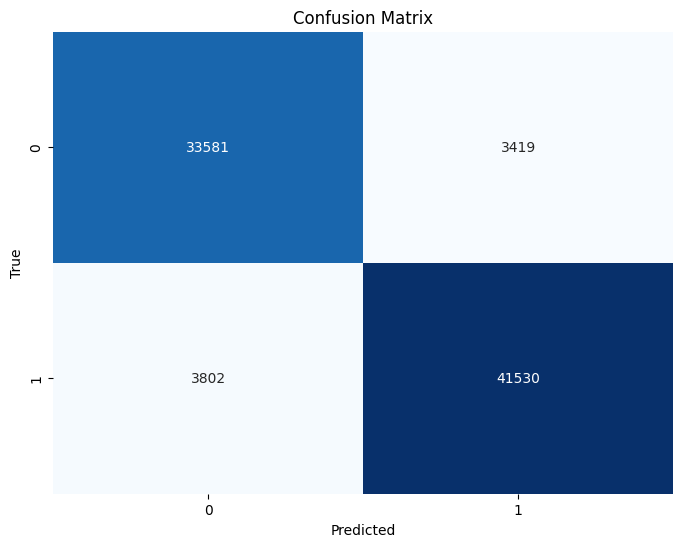

In [ ]:
X_test = norm_testset.iloc[:, :-1]
y_test = norm_testset.iloc[:, -1]

test_dataset = TabularDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

evaluate_model(model, test_loader)